### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
np.random.seed(5)
import time
import sys

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params, keep_prob):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    a1_c = tf.nn.dropout(a1_c, keep_prob, seed=2)
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
    a1_p = tf.nn.dropout(a1_p, keep_prob, seed=2)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    a2_c = tf.nn.dropout(a2_c, keep_prob, seed=2)
    
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    a2_p = tf.nn.dropout(a2_p, keep_prob, seed=2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    a4 = tf.nn.dropout(a4, keep_prob, seed=2)
    print(a4)
    
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 4
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 4
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [7]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params, keep_prob)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            old_cost = new_cost
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            new_cost = epoch_cost
            cost_history.append(epoch_cost)
            if(abs(old_cost - new_cost) < 0.00000000001):
                print("breaking" + str(old_cost) + str(new_cost))
                break;
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        elapsed_time = time.time() - start_time
        print("Time elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

Instructions for updating:
Use the retry module or similar alternatives.
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.21666666865348816
Accuracy Test: 0.21666667 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.24444444477558136
Accuracy Test: 0.24444444 on iteration 1
Cost is 1.7858386 for iteration: 1
Accuracy Test: 0.16666667 on iteration 2
Cost is 1.7542149 for iteration: 2
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 3
Cost is 1.7787324 for iteration: 3
Max till now is  0.28333333134651184
Accuracy Test

Accuracy Test: 0.8388889 on iteration 86
Cost is 1.1785607 for iteration: 86
Accuracy Test: 0.82222223 on iteration 87
Cost is 1.173828 for iteration: 87
Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1765313 for iteration: 88
Accuracy Test: 0.85 on iteration 89
Cost is 1.1661994 for iteration: 89
Accuracy Test: 0.82222223 on iteration 90
Cost is 1.1722772 for iteration: 90
Accuracy Test: 0.8 on iteration 91
Cost is 1.1701682 for iteration: 91
Accuracy Test: 0.8388889 on iteration 92
Cost is 1.1731213 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.169462 for iteration: 93
Accuracy Test: 0.85 on iteration 94
Cost is 1.1599119 for iteration: 94
Accuracy Test: 0.8333333 on iteration 95
Cost is 1.162022 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1576252 for iteration: 96
Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 97
Cost is 1.1545086 for iteration: 97
Accuracy Test: 0.85 on iteration 98
Cost is 1.15575 for

Accuracy Test: 0.9111111 on iteration 188
Cost is 1.1004419 for iteration: 188
Accuracy Test: 0.87777776 on iteration 189
Cost is 1.0994387 for iteration: 189
Accuracy Test: 0.9166667 on iteration 190
Cost is 1.1027706 for iteration: 190
Accuracy Test: 0.87777776 on iteration 191
Cost is 1.102037 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.1064386 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.1107353 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.1015475 for iteration: 194
Accuracy Test: 0.9166667 on iteration 195
Cost is 1.0988092 for iteration: 195
Accuracy Test: 0.8888889 on iteration 196
Cost is 1.1007775 for iteration: 196
Accuracy Test: 0.87777776 on iteration 197
Cost is 1.1009731 for iteration: 197
Max till now is  0.9277777671813965
Accuracy Test: 0.92777777 on iteration 198
Cost is 1.1031021 for iteration: 198
Accuracy Test: 0.8888889 on iteration 199
Cost is 1.1016095 for iteration: 199
Accuracy Test

Accuracy Test: 0.92777777 on iteration 292
Cost is 1.0698347 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0786008 for iteration: 293
Accuracy Test: 0.9 on iteration 294
Cost is 1.0798178 for iteration: 294
Accuracy Test: 0.9222222 on iteration 295
Cost is 1.0765172 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0885458 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0834205 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0816436 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.0804042 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0824527 for iteration: 300


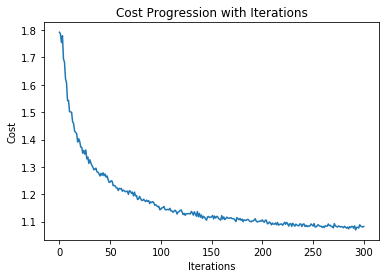

Train Accuracy:  95.1960802078247
Test Accuracy:  92.22221970558167
Max Test Accuracy: 94.44444179534912 on iteration 283
Time elapsed :  6.611748898029328
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 0
Cost is 1.7918481 for iteration: 0
Accuracy Test: 0.17222223 on iteration 1
Cost is 1.7798332 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.7730035 for iteration: 2
Max till now is  0.20555555820465088
Accuracy Test: 0.20555556 on iteration 3
Cost is 1.7677611 for iteration: 3
Max till n

Accuracy Test: 0.8333333 on iteration 87
Cost is 1.1639858 for iteration: 87
Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1673708 for iteration: 88
Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 89
Cost is 1.1638613 for iteration: 89
Accuracy Test: 0.81666666 on iteration 90
Cost is 1.169673 for iteration: 90
Accuracy Test: 0.85555553 on iteration 91
Cost is 1.1713136 for iteration: 91
Accuracy Test: 0.85 on iteration 92
Cost is 1.16465 for iteration: 92
Accuracy Test: 0.84444445 on iteration 93
Cost is 1.1685508 for iteration: 93
Accuracy Test: 0.8388889 on iteration 94
Cost is 1.1472008 for iteration: 94
Accuracy Test: 0.8111111 on iteration 95
Cost is 1.1510302 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1536278 for iteration: 96
Accuracy Test: 0.84444445 on iteration 97
Cost is 1.162209 for iteration: 97
Accuracy Test: 0.85 on iteration 98
Cost is 1.1510887 for iteration: 98
Accuracy Test: 0.8388889 on iteration 99
Cost is 

Accuracy Test: 0.8888889 on iteration 189
Cost is 1.0911334 for iteration: 189
Accuracy Test: 0.87777776 on iteration 190
Cost is 1.0956621 for iteration: 190
Accuracy Test: 0.8888889 on iteration 191
Cost is 1.0868512 for iteration: 191
Accuracy Test: 0.8888889 on iteration 192
Cost is 1.0940961 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0868527 for iteration: 193
Accuracy Test: 0.90555555 on iteration 194
Cost is 1.084087 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0863119 for iteration: 195
Accuracy Test: 0.8888889 on iteration 196
Cost is 1.0890353 for iteration: 196
Accuracy Test: 0.9 on iteration 197
Cost is 1.089942 for iteration: 197
Accuracy Test: 0.8888889 on iteration 198
Cost is 1.0859326 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.083794 for iteration: 199
Accuracy Test: 0.87777776 on iteration 200
Cost is 1.084758 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.085887

Accuracy Test: 0.92777777 on iteration 292
Cost is 1.0723399 for iteration: 292
Accuracy Test: 0.9388889 on iteration 293
Cost is 1.0721769 for iteration: 293
Accuracy Test: 0.9222222 on iteration 294
Cost is 1.07032 for iteration: 294
Accuracy Test: 0.9388889 on iteration 295
Cost is 1.0750514 for iteration: 295
Accuracy Test: 0.9222222 on iteration 296
Cost is 1.068802 for iteration: 296
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 297
Cost is 1.0681977 for iteration: 297
Accuracy Test: 0.9222222 on iteration 298
Cost is 1.0694783 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0747521 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0765065 for iteration: 300


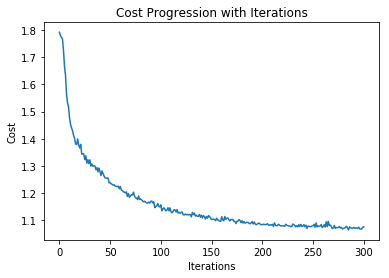

Train Accuracy:  97.64705896377563
Test Accuracy:  93.88889074325562
Max Test Accuracy: 94.9999988079071 on iteration 297
Time elapsed :  6.523039583365122
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23888888955116272
Accuracy Test: 0.23888889 on iteration 0
Cost is 1.7920426 for iteration: 0
Accuracy Test: 0.17777778 on iteration 1
Cost is 1.782083 for iteration: 1
Max till now is  0.3166666626930237
Accuracy Test: 0.31666666 on iteration 2
Cost is 1.7883056 for iteration: 2
Accuracy Test: 0.2888889 on iteration 3
Cost is 1.7465982 for iteration: 3
Accura

Accuracy Test: 0.8611111 on iteration 89
Cost is 1.1304795 for iteration: 89
Accuracy Test: 0.81666666 on iteration 90
Cost is 1.120896 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.1441126 for iteration: 91
Accuracy Test: 0.8666667 on iteration 92
Cost is 1.1387516 for iteration: 92
Accuracy Test: 0.85555553 on iteration 93
Cost is 1.1240215 for iteration: 93
Accuracy Test: 0.8666667 on iteration 94
Cost is 1.1238096 for iteration: 94
Accuracy Test: 0.87222224 on iteration 95
Cost is 1.1148996 for iteration: 95
Accuracy Test: 0.8888889 on iteration 96
Cost is 1.1210544 for iteration: 96
Accuracy Test: 0.8277778 on iteration 97
Cost is 1.1190133 for iteration: 97
Accuracy Test: 0.8611111 on iteration 98
Cost is 1.1267478 for iteration: 98
Max till now is  0.8999999761581421
Accuracy Test: 0.9 on iteration 99
Cost is 1.1102465 for iteration: 99
Accuracy Test: 0.8833333 on iteration 100
Cost is 1.1211189 for iteration: 100
Accuracy Test: 0.85555553 on iteration 101

Accuracy Test: 0.92777777 on iteration 192
Cost is 1.0692319 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0675749 for iteration: 193
Accuracy Test: 0.92777777 on iteration 194
Cost is 1.0686384 for iteration: 194
Accuracy Test: 0.9 on iteration 195
Cost is 1.0714896 for iteration: 195
Max till now is  0.9333333373069763
Accuracy Test: 0.93333334 on iteration 196
Cost is 1.074177 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0688114 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0713469 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.066087 for iteration: 199
Accuracy Test: 0.9111111 on iteration 200
Cost is 1.069858 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.0686603 for iteration: 201
Accuracy Test: 0.92777777 on iteration 202
Cost is 1.0636514 for iteration: 202
Accuracy Test: 0.8888889 on iteration 203
Cost is 1.072822 for iteration: 203
Accuracy Test: 0.9222

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0550206 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0593233 for iteration: 296
Accuracy Test: 0.9166667 on iteration 297
Cost is 1.0612867 for iteration: 297
Accuracy Test: 0.9166667 on iteration 298
Cost is 1.0571965 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0582459 for iteration: 299
Accuracy Test: 0.92777777 on iteration 300
Cost is 1.0615302 for iteration: 300


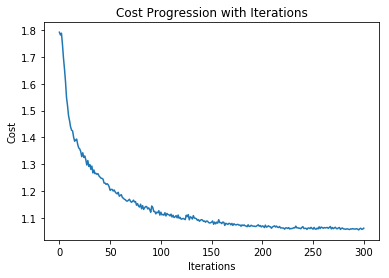

Train Accuracy:  98.82352948188782
Test Accuracy:  92.77777671813965
Max Test Accuracy: 95.55555582046509 on iteration 267
Time elapsed :  6.524835447470347
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 1
Cost is 1.8046367 for iteration: 1
Accuracy Test: 0.15555556 on iteration 2
Cost is 1.7819648 for iteration: 2
Max till now is  0.24444444477558136
Accuracy Test: 0.24444444 on iteration 3
C

Accuracy Test: 0.8277778 on iteration 89
Cost is 1.1508625 for iteration: 89
Accuracy Test: 0.81666666 on iteration 90
Cost is 1.15418 for iteration: 90
Accuracy Test: 0.84444445 on iteration 91
Cost is 1.1506596 for iteration: 91
Accuracy Test: 0.84444445 on iteration 92
Cost is 1.1401575 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.1539626 for iteration: 93
Accuracy Test: 0.85 on iteration 94
Cost is 1.1491171 for iteration: 94
Accuracy Test: 0.81666666 on iteration 95
Cost is 1.1474751 for iteration: 95
Accuracy Test: 0.8055556 on iteration 96
Cost is 1.1445326 for iteration: 96
Accuracy Test: 0.8388889 on iteration 97
Cost is 1.1410216 for iteration: 97
Accuracy Test: 0.8333333 on iteration 98
Cost is 1.1315782 for iteration: 98
Accuracy Test: 0.82222223 on iteration 99
Cost is 1.1427495 for iteration: 99
Accuracy Test: 0.85 on iteration 100
Cost is 1.138321 for iteration: 100
Accuracy Test: 0.84444445 on iteration 101
Cost is 1.1347913 for iteration: 101
M

Accuracy Test: 0.8888889 on iteration 191
Cost is 1.0930752 for iteration: 191
Accuracy Test: 0.8833333 on iteration 192
Cost is 1.0921229 for iteration: 192
Accuracy Test: 0.8666667 on iteration 193
Cost is 1.0859228 for iteration: 193
Accuracy Test: 0.89444447 on iteration 194
Cost is 1.0839074 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.094201 for iteration: 195
Accuracy Test: 0.9 on iteration 196
Cost is 1.0889359 for iteration: 196
Accuracy Test: 0.89444447 on iteration 197
Cost is 1.0880542 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.089807 for iteration: 198
Accuracy Test: 0.8888889 on iteration 199
Cost is 1.0853341 for iteration: 199
Accuracy Test: 0.89444447 on iteration 200
Cost is 1.0840434 for iteration: 200
Accuracy Test: 0.8888889 on iteration 201
Cost is 1.0875986 for iteration: 201
Accuracy Test: 0.8666667 on iteration 202
Cost is 1.0827255 for iteration: 202
Accuracy Test: 0.9 on iteration 203
Cost is 1.0867189 for

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0746286 for iteration: 295
Accuracy Test: 0.8888889 on iteration 296
Cost is 1.0791824 for iteration: 296
Accuracy Test: 0.89444447 on iteration 297
Cost is 1.0746071 for iteration: 297
Accuracy Test: 0.9111111 on iteration 298
Cost is 1.0748428 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.0729754 for iteration: 299
Accuracy Test: 0.9 on iteration 300
Cost is 1.0747596 for iteration: 300


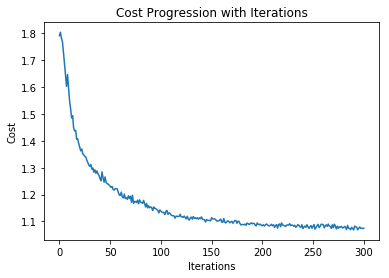

Train Accuracy:  97.7450966835022
Test Accuracy:  89.99999761581421
Max Test Accuracy: 93.33333373069763 on iteration 220
Time elapsed :  7.6230694850285845
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7918481 for iteration: 0
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 1
Cost is 1.7986438 for iteration: 1
Max till now is  0.2222222238779068
Accuracy Test: 0.22222222 on iteration 2
Cost is 1.7571049 for iteration: 2
Max till now is  0.28333333134651184
Accur

Max till now is  0.8500000238418579
Accuracy Test: 0.85 on iteration 87
Cost is 1.1648306 for iteration: 87
Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1486704 for iteration: 88
Accuracy Test: 0.8333333 on iteration 89
Cost is 1.1590128 for iteration: 89
Accuracy Test: 0.8333333 on iteration 90
Cost is 1.1494523 for iteration: 90
Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1515317 for iteration: 91
Accuracy Test: 0.8277778 on iteration 92
Cost is 1.1623371 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.1550915 for iteration: 93
Accuracy Test: 0.8277778 on iteration 94
Cost is 1.1389219 for iteration: 94
Accuracy Test: 0.8055556 on iteration 95
Cost is 1.1584136 for iteration: 95
Accuracy Test: 0.81666666 on iteration 96
Cost is 1.1394445 for iteration: 96
Accuracy Test: 0.82222223 on iteration 97
Cost is 1.1406933 for iteration: 97
Accuracy Test: 0.8111111 on iteration 98
Cost is 1.1501789 for iteration: 98
Max till now is  0.8611111044883728
Accur

Accuracy Test: 0.9 on iteration 187
Cost is 1.0890932 for iteration: 187
Accuracy Test: 0.9 on iteration 188
Cost is 1.0852792 for iteration: 188
Accuracy Test: 0.8888889 on iteration 189
Cost is 1.0804536 for iteration: 189
Accuracy Test: 0.8888889 on iteration 190
Cost is 1.0865581 for iteration: 190
Accuracy Test: 0.85555553 on iteration 191
Cost is 1.0861408 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0821723 for iteration: 192
Accuracy Test: 0.87222224 on iteration 193
Cost is 1.0816747 for iteration: 193
Accuracy Test: 0.89444447 on iteration 194
Cost is 1.0864532 for iteration: 194
Accuracy Test: 0.8888889 on iteration 195
Cost is 1.0916355 for iteration: 195
Accuracy Test: 0.87222224 on iteration 196
Cost is 1.0826399 for iteration: 196
Accuracy Test: 0.8888889 on iteration 197
Cost is 1.0828602 for iteration: 197
Accuracy Test: 0.87777776 on iteration 198
Cost is 1.0813549 for iteration: 198
Accuracy Test: 0.9 on iteration 199
Cost is 1.0808575 for 

Accuracy Test: 0.9 on iteration 292
Cost is 1.077293 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0698792 for iteration: 293
Accuracy Test: 0.87777776 on iteration 294
Cost is 1.0747204 for iteration: 294
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 295
Cost is 1.0714028 for iteration: 295
Accuracy Test: 0.87222224 on iteration 296
Cost is 1.0685878 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.067609 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0748847 for iteration: 298
Accuracy Test: 0.9 on iteration 299
Cost is 1.0714695 for iteration: 299
Accuracy Test: 0.9 on iteration 300
Cost is 1.0688818 for iteration: 300


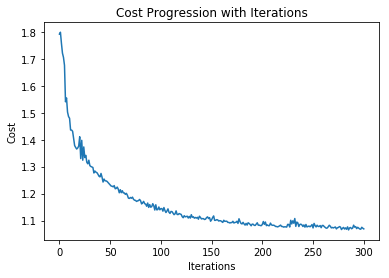

Train Accuracy:  97.84313440322876
Test Accuracy:  89.99999761581421
Max Test Accuracy: 94.44444179534912 on iteration 295
Time elapsed :  7.766754535833995
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.21111111342906952
Accuracy Test: 0.21111111 on iteration 0
Cost is 1.7920426 for iteration: 0
Accuracy Test: 0.15 on iteration 1
Cost is 1.806849 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.8084736 for iteration: 2
Accuracy Test: 0.15 on iteration 3
Cost is 1.8069563 for iteration: 3
Max till now is  0.2777777910232544
Accuracy Test: 0.27777

Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1491265 for iteration: 91
Accuracy Test: 0.8333333 on iteration 92
Cost is 1.1350569 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.1386896 for iteration: 93
Accuracy Test: 0.8333333 on iteration 94
Cost is 1.1306359 for iteration: 94
Accuracy Test: 0.8388889 on iteration 95
Cost is 1.1326647 for iteration: 95
Accuracy Test: 0.85 on iteration 96
Cost is 1.1384069 for iteration: 96
Accuracy Test: 0.84444445 on iteration 97
Cost is 1.1392299 for iteration: 97
Accuracy Test: 0.82222223 on iteration 98
Cost is 1.1379333 for iteration: 98
Max till now is  0.8722222447395325
Accuracy Test: 0.87222224 on iteration 99
Cost is 1.1306249 for iteration: 99
Max till now is  0.8777777552604675
Accuracy Test: 0.87777776 on iteration 100
Cost is 1.1251975 for iteration: 100
Accuracy Test: 0.82222223 on iteration 101
Cost is 1.1226833 for iteration: 101
Accuracy Test: 0.87222224 on iteration 102
Cost is 1.1284425 for iteration:

Accuracy Test: 0.90555555 on iteration 194
Cost is 1.0681928 for iteration: 194
Accuracy Test: 0.8888889 on iteration 195
Cost is 1.0703447 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0703926 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0657502 for iteration: 197
Accuracy Test: 0.87222224 on iteration 198
Cost is 1.0648751 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0708568 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0637664 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0653697 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0624228 for iteration: 202
Accuracy Test: 0.8888889 on iteration 203
Cost is 1.0665946 for iteration: 203
Accuracy Test: 0.9166667 on iteration 204
Cost is 1.0699496 for iteration: 204
Accuracy Test: 0.9111111 on iteration 205
Cost is 1.0663877 for iteration: 205
Accuracy Test: 0.89444447 on iteration 206
Cost

Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0549716 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.062067 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0586866 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0599036 for iteration: 300


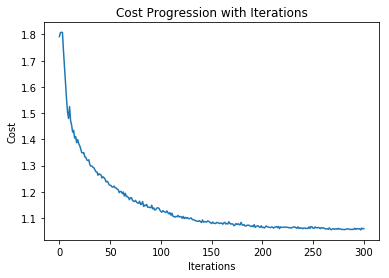

Train Accuracy:  98.52941036224365
Test Accuracy:  93.88889074325562
Max Test Accuracy: 94.9999988079071 on iteration 289
Time elapsed :  7.709652066230774
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.21666666865348816
Accuracy Test: 0.21666667 on iteration 1
Cost is 1.7887497 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.7582229 for iteration: 2
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 3
Cost is 1

Accuracy Test: 0.8277778 on iteration 87
Cost is 1.1758163 for iteration: 87
Accuracy Test: 0.8277778 on iteration 88
Cost is 1.1738194 for iteration: 88
Accuracy Test: 0.82222223 on iteration 89
Cost is 1.1677518 for iteration: 89
Accuracy Test: 0.8388889 on iteration 90
Cost is 1.1645738 for iteration: 90
Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1713529 for iteration: 91
Accuracy Test: 0.8 on iteration 92
Cost is 1.1614211 for iteration: 92
Accuracy Test: 0.8388889 on iteration 93
Cost is 1.1690925 for iteration: 93
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 94
Cost is 1.1630133 for iteration: 94
Accuracy Test: 0.85 on iteration 95
Cost is 1.1640779 for iteration: 95
Accuracy Test: 0.8277778 on iteration 96
Cost is 1.1511359 for iteration: 96
Accuracy Test: 0.8611111 on iteration 97
Cost is 1.163121 for iteration: 97
Accuracy Test: 0.85555553 on iteration 98
Cost is 1.1568377 for iteration: 98
Max till now is  0.8722222447395325
Accuracy Test

Accuracy Test: 0.8666667 on iteration 188
Cost is 1.0983815 for iteration: 188
Accuracy Test: 0.87222224 on iteration 189
Cost is 1.0976359 for iteration: 189
Accuracy Test: 0.90555555 on iteration 190
Cost is 1.1033207 for iteration: 190
Accuracy Test: 0.87777776 on iteration 191
Cost is 1.1050587 for iteration: 191
Accuracy Test: 0.84444445 on iteration 192
Cost is 1.1052347 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.1074845 for iteration: 193
Max till now is  0.9222221970558167
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.1147122 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0945629 for iteration: 195
Accuracy Test: 0.8833333 on iteration 196
Cost is 1.097674 for iteration: 196
Accuracy Test: 0.9166667 on iteration 197
Cost is 1.0997213 for iteration: 197
Accuracy Test: 0.9 on iteration 198
Cost is 1.0969999 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.1004992 for iteration: 199
Accuracy Test: 0

Accuracy Test: 0.90555555 on iteration 291
Cost is 1.0782179 for iteration: 291
Accuracy Test: 0.9166667 on iteration 292
Cost is 1.0696158 for iteration: 292
Accuracy Test: 0.92777777 on iteration 293
Cost is 1.0753757 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0722758 for iteration: 294
Accuracy Test: 0.9222222 on iteration 295
Cost is 1.0735754 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0806652 for iteration: 296
Accuracy Test: 0.90555555 on iteration 297
Cost is 1.0721194 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0798014 for iteration: 298
Accuracy Test: 0.9 on iteration 299
Cost is 1.0816007 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.0757732 for iteration: 300


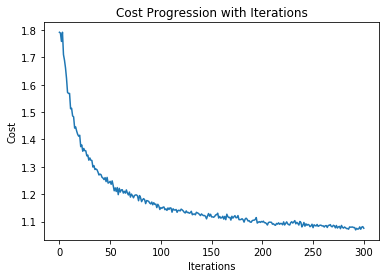

Train Accuracy:  95.78431248664856
Test Accuracy:  93.88889074325562
Max Test Accuracy: 94.9999988079071 on iteration 272
Time elapsed :  7.839955981572469
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7918481 for iteration: 0
Accuracy Test: 0.17222223 on iteration 1
Cost is 1.7823824 for iteration: 1
Accuracy Test: 0.15555556 on iteration 2
Cost is 1.7733799 for iteration: 2
Max till now is  0.20000000298023224
Accuracy Test: 0.2 on iteration 3
Cost is 1.7649843 for iteration: 3
Max till n

Accuracy Test: 0.8277778 on iteration 86
Cost is 1.150373 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.1485922 for iteration: 87
Accuracy Test: 0.81666666 on iteration 88
Cost is 1.1478962 for iteration: 88
Accuracy Test: 0.8388889 on iteration 89
Cost is 1.1631566 for iteration: 89
Accuracy Test: 0.85555553 on iteration 90
Cost is 1.1498297 for iteration: 90
Accuracy Test: 0.85 on iteration 91
Cost is 1.1464992 for iteration: 91
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1469356 for iteration: 92
Accuracy Test: 0.8333333 on iteration 93
Cost is 1.1429708 for iteration: 93
Accuracy Test: 0.82222223 on iteration 94
Cost is 1.1390183 for iteration: 94
Accuracy Test: 0.85555553 on iteration 95
Cost is 1.1369799 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1351316 for iteration: 96
Accuracy Test: 0.8388889 on iteration 97
Cost is 1.1458097 for iteration: 97
Accuracy Test: 0.85 on iteration 98
Cost is 1.1550813 for iteration: 98
Max 

Accuracy Test: 0.92777777 on iteration 188
Cost is 1.0786577 for iteration: 188
Accuracy Test: 0.89444447 on iteration 189
Cost is 1.084881 for iteration: 189
Accuracy Test: 0.8888889 on iteration 190
Cost is 1.0833575 for iteration: 190
Accuracy Test: 0.85555553 on iteration 191
Cost is 1.0842217 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.0876322 for iteration: 192
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 193
Cost is 1.0800833 for iteration: 193
Accuracy Test: 0.93333334 on iteration 194
Cost is 1.0815445 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0806079 for iteration: 195
Accuracy Test: 0.9166667 on iteration 196
Cost is 1.0821859 for iteration: 196
Accuracy Test: 0.9111111 on iteration 197
Cost is 1.0774299 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0779504 for iteration: 198
Accuracy Test: 0.8833333 on iteration 199
Cost is 1.0752182 for iteration: 199
Accuracy Tes

Accuracy Test: 0.9222222 on iteration 292
Cost is 1.0660799 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.063673 for iteration: 293
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 294
Cost is 1.0617137 for iteration: 294
Accuracy Test: 0.9444444 on iteration 295
Cost is 1.0659072 for iteration: 295
Accuracy Test: 0.93333334 on iteration 296
Cost is 1.0662315 for iteration: 296
Accuracy Test: 0.9388889 on iteration 297
Cost is 1.0613102 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.063148 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.0618966 for iteration: 299
Max till now is  0.9611111283302307
Accuracy Test: 0.9611111 on iteration 300
Cost is 1.0606524 for iteration: 300


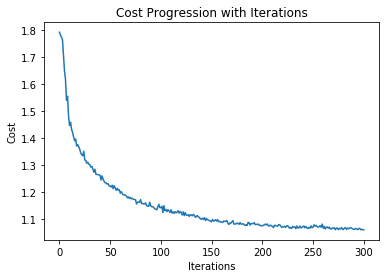

Train Accuracy:  97.64705896377563
Test Accuracy:  96.11111283302307
Max Test Accuracy: 96.11111283302307 on iteration 300
Time elapsed :  7.802454264958699
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920426 for iteration: 0
Accuracy Test: 0.2 on iteration 1
Cost is 1.7858785 for iteration: 1
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 2
Cost is 1.7977575 for iteration: 2
Accuracy Test: 0.28333333 on iteration 3
Cost is 1.753066 for iteration: 3
Accuracy Te

Accuracy Test: 0.8666667 on iteration 89
Cost is 1.125375 for iteration: 89
Accuracy Test: 0.82222223 on iteration 90
Cost is 1.126342 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.1243241 for iteration: 91
Accuracy Test: 0.8666667 on iteration 92
Cost is 1.1380947 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.1193 for iteration: 93
Accuracy Test: 0.87222224 on iteration 94
Cost is 1.1220943 for iteration: 94
Accuracy Test: 0.84444445 on iteration 95
Cost is 1.1169759 for iteration: 95
Accuracy Test: 0.85555553 on iteration 96
Cost is 1.1204333 for iteration: 96
Accuracy Test: 0.85 on iteration 97
Cost is 1.1181444 for iteration: 97
Accuracy Test: 0.85555553 on iteration 98
Cost is 1.1256871 for iteration: 98
Max till now is  0.8888888955116272
Accuracy Test: 0.8888889 on iteration 99
Cost is 1.10955 for iteration: 99
Accuracy Test: 0.87777776 on iteration 100
Cost is 1.1105864 for iteration: 100
Accuracy Test: 0.85 on iteration 101
Cost i

Accuracy Test: 0.8888889 on iteration 192
Cost is 1.0664915 for iteration: 192
Accuracy Test: 0.87777776 on iteration 193
Cost is 1.0662336 for iteration: 193
Accuracy Test: 0.90555555 on iteration 194
Cost is 1.0711509 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0650986 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0711099 for iteration: 196
Accuracy Test: 0.9111111 on iteration 197
Cost is 1.066217 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0661294 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0652214 for iteration: 199
Max till now is  0.9277777671813965
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0681534 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.0624969 for iteration: 201
Accuracy Test: 0.9166667 on iteration 202
Cost is 1.0659738 for iteration: 202
Accuracy Test: 0.9 on iteration 203
Cost is 1.0675136 for iteration: 203
Accuracy Test: 0.9 o

Accuracy Test: 0.9166667 on iteration 295
Cost is 1.0571548 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0575755 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0575254 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.054221 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.056411 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0575255 for iteration: 300


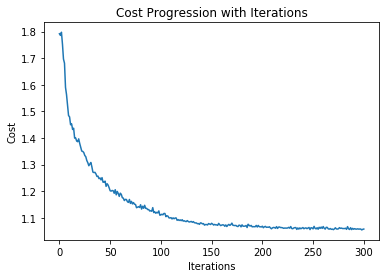

Train Accuracy:  98.82352948188782
Test Accuracy:  92.22221970558167
Max Test Accuracy: 93.88889074325562 on iteration 222
Time elapsed :  7.778131997585296


In [8]:
for learning_rate in [0.01, 0.015, 0.011]:
    for keep_prob in [0.7, 0.8, 0.9]:
        train_cnn_lenet5(300, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, learning_rate, keep_prob)

### 5. (20pts) Predictions